## TF 2.0 构建线性回归/神经网络

#### 目录

**线性回归**
- 低阶 API 实现
- 高阶 API 实现

**神经网络**
- 低阶 API 实现
- 高阶 API 实现

---

## 线性回归

接下来，以线性回归为例，使用 TensorFlow 2.0 提供的 API 和 Eager Execution 机制对其进行实现。

### 低阶 API 实现

低阶 API 实现，实际上就是利用 Eager Execution 机制来完成。实验首先初始化一组随机数据样本，并添加噪声，然后将其可视化出来。

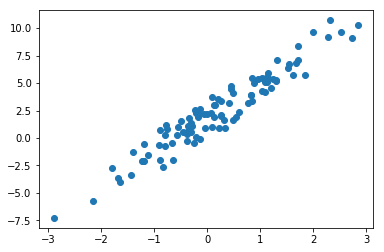

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

TRUE_W = 3.0
TRUE_b = 2.0
NUM_SAMPLES = 100

# 初始化随机数据
X = tf.random.normal(shape=[NUM_SAMPLES, 1]).numpy()
noise = tf.random.normal(shape=[NUM_SAMPLES, 1]).numpy()
y = X * TRUE_W + TRUE_b + noise  # 添加噪声

plt.scatter(X, y)

接下来，定义一元线性回归模型。

$$
f(w, b, x) = w*x + b
$$

这里构建自定义模型类，并使用 TensorFlow 提供的 `tf.Variable` 随机初始化参数 $w$ 和截距项 $b$。

In [2]:
class Model(object):
    def __init__(self):
        self.W = tf.Variable(tf.random.uniform([1]))  # 随机初始化参数
        self.b = tf.Variable(tf.random.uniform([1]))

    def __call__(self, x):
        return self.W * x + self.b  # w*x + b

对于随机初始化的 $w$ 和 $b$，可以将其拟合直线绘制到样本散点图中。

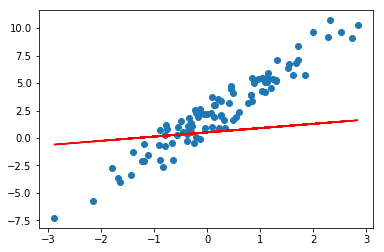

In [3]:
model = Model()  # 实例化模型

plt.scatter(X, y)
plt.plot(X, model(X), c='r')

可以明显看出，直线并没有很好地拟合样本。当然，由于是随机初始化，也有极小概率一开始拟合效果非常好，那么重新执行一次上面的单元格另外随机初始化一组数据即可。

然后，定义线性回归使用到的损失函数。这里使用线性回归问题中常用的平方损失函数。

$$
{\rm Loss}(w, b, x, y) = \sum_{i=1}^N (f(w, b, x_i) - y_i)^2
$$

根据公式实现损失计算函数。

In [4]:
def loss_fn(model, x, y):
    y_ = model(x)
    return tf.reduce_mean(tf.square(y_ - y))

接下来，就可以开始迭代过程了，这也是最关键的一步。使用迭代方法求解线性回归的问题中，首先需要计算参数的梯度，然后使用梯度下降法来更新参数。

$$
\begin{align}
w &\leftarrow w - lr * \frac{\partial {\rm loss}(w, b)}{\partial w} \\\
b &\leftarrow b - lr * \frac{\partial {\rm loss}(w, b)}{\partial b}
\end{align}
$$

公式中，$lr$ 指代学习率。

TensorFlow 2.0 中的 Eager Execution 提供了 `tf.GradientTape` 用于追踪梯度。所以，下面实现梯度下降法的迭代更新过程。

In [5]:
EPOCHS = 10
LEARNING_RATE = 0.1

for epoch in range(EPOCHS):  # 迭代次数
    with tf.GradientTape() as tape:  # 追踪梯度
        loss = loss_fn(model, X, y)  # 计算损失
    dW, db = tape.gradient(loss, [model.W, model.b])  # 计算梯度
    model.W.assign_sub(LEARNING_RATE * dW)  # 更新梯度
    model.b.assign_sub(LEARNING_RATE * db)
    # 输出计算过程
    print('Epoch [{}/{}], loss [{:.3f}], W/b [{:.3f}/{:.3f}]'.format(epoch+1, EPOCHS, loss,
                                                                     float(model.W.numpy()),
                                                                     float(model.b.numpy())))

Epoch [1/10], loss [12.828], W/b [1.098/0.891]
Epoch [2/10], loss [7.236], W/b [1.618/1.162]
Epoch [3/10], loss [4.268], W/b [1.998/1.357]
Epoch [4/10], loss [2.692], W/b [2.275/1.497]
Epoch [5/10], loss [1.854], W/b [2.479/1.598]
Epoch [6/10], loss [1.410], W/b [2.627/1.670]
Epoch [7/10], loss [1.174], W/b [2.736/1.722]
Epoch [8/10], loss [1.048], W/b [2.816/1.758]
Epoch [9/10], loss [0.981], W/b [2.874/1.785]
Epoch [10/10], loss [0.946], W/b [2.917/1.803]


上面的代码中，我们初始化 `tf.GradientTape()` 以追踪梯度，然后使用 `tape.gradient` 方法就可以计算梯度了。值得注意的是，`tape.gradient()` 第二个参数支持以列表形式传入多个参数同时计算梯度。紧接着，使用 `.assign_sub` 即可完成公式中的减法操作用以更新梯度。

最终，我们绘制参数学习完成之后，模型的拟合结果。

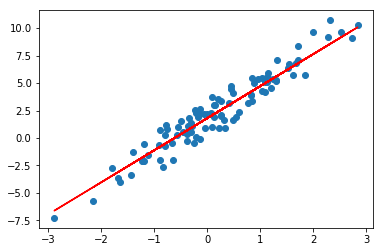

In [6]:
plt.scatter(X, y)
plt.plot(X, model(X), c='r')

如无意外，你将得到一个比随机参数好很多的拟合直线。

<i class="fa fa-exclamation-circle" aria-hidden="true"> 提示：</i>由于是随机初始化参数，如果迭代后拟合效果仍然不好，一般是迭代次数太少的原因。可以重复执行上面的迭代单元格多次，增加参数更新迭代次数，即可改善拟合效果。此提示对后面的内容同样有效。

### 高阶 API 实现

TensorFlow 2.0 中提供了大量的高阶 API 帮助我们快速构建所需模型，接下来，我们使用一些新的 API 来完成线性回归模型的构建。这里还是沿用上面提供的示例数据。

`tf.keras` 模块下提供的 `tf.keras.layers.Dense` 全连接层（线性层）实际上就是一个线性计算过程。所以，模型的定义部分我们就可以直接实例化一个全连接层即可。

In [7]:
model = tf.keras.layers.Dense(units=1)  # 实例化线性层
model

其中，`units` 为输出空间维度。此时，参数已经被初始化了，所以我们可以绘制出拟合直线。

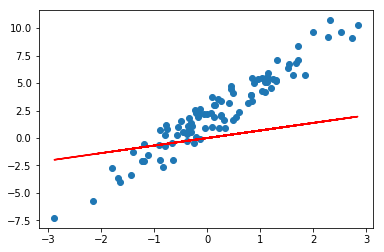

In [8]:
plt.scatter(X, y)
plt.plot(X, model(X), c='r')

可以使用 `model.variables` 打印出模型初始化的随机参数。

In [9]:
model.variables

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.68697464]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

接下来就可以直接构建模型迭代过程了。

这里同样使用 `tf.GradientTape()` 来追踪梯度，我们简化损失计算和更新的过程。首先，损失可以使用现有 API `tf.keras.losses.mean_squared_error` 计算，最终使用 `tf.reduce_sum` 求得全部样本的平均损失。

In [10]:
EPOCHS = 10
LEARNING_RATE = 0.002
for epoch in range(EPOCHS):  # 迭代次数
    with tf.GradientTape() as tape:  # 追踪梯度
        y_ = model(X)
        loss = tf.reduce_sum(tf.keras.losses.mean_squared_error(y, y_))  # 计算损失

    grads = tape.gradient(loss, model.variables)  # 计算梯度
    optimizer = tf.keras.optimizers.SGD(LEARNING_RATE)  # 随机梯度下降
    optimizer.apply_gradients(zip(grads, model.variables))  # 更新梯度

    print('Epoch [{}/{}], loss [{:.3f}]'.format(epoch+1, EPOCHS, loss))

Epoch [1/10], loss [1293.861]
Epoch [2/10], loss [345.017]
Epoch [3/10], loss [145.012]
Epoch [4/10], loss [102.460]
Epoch [5/10], loss [93.243]
Epoch [6/10], loss [91.180]
Epoch [7/10], loss [90.690]
Epoch [8/10], loss [90.564]
Epoch [9/10], loss [90.527]
Epoch [10/10], loss [90.515]


其次，使用 `model.variables` 即可读取可参数的列表，无需像上面那样手动传入。这里不再按公式手动更新梯度，而是使用现有的随机梯度下降函数 `tf.keras.optimizers.SGD`，然后使用 `apply_gradients` 即可更新梯度。

最终，同样将迭代完成的参数绘制拟合直线到原图中。

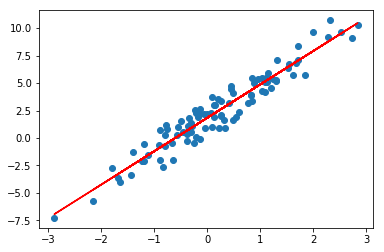

In [11]:
plt.scatter(X, y)
plt.plot(X, model(X), c='r')

### Keras 方式实现

上面的高阶 API 实现过程实际上还不够精简，我们可以完全使用 TensorFlow Keras API 来实现线性回归。

我们这里使用 Keras 提供的 Sequential 序贯模型结构。和上面的例子相似，向其中添加一个线性层。不同的地方在于，Keras 序贯模型第一层为线性层时，规定需指定输入维度，这里为 `input_dim=1`。

In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=1, input_dim=1))
model.summary()  # 查看模型结构

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


接下来，直接使用 `.compile` 编译模型，指定损失函数为 MSE 平方损失，优化器选择 SGD 随机梯度下降。然后，就可以使用 `.fit` 传入数据开始迭代了。

model.compile(optimizer='sgd', loss='mse')
model.fit(X, y, steps_per_epoch=1000)

`steps_per_epoch` 只的是在默认小批量为 32 的条件下，传入相应次数的小批量样本。最终绘制出迭代完成的拟合图像。

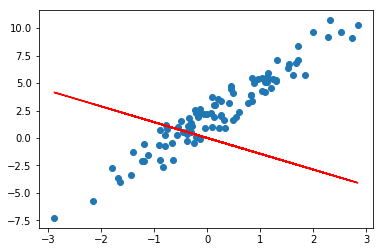

In [13]:
plt.scatter(X, y)
plt.plot(X, model(X), c='r')

如上所示，完全使用 Keras 高阶 API 实际上只需要 4 行核心代码即可完成。相比于最开始的低阶 API 简化了很多。

## 神经网络

### 低阶 API 构建

了解了线性回归中的低阶 API 实现方法，那使用 TensorFlow 2.0 低阶 API 构建神经网络实际上就比较简单了。这里，我们先加载一组数据，DIGITS 数据集是 scikit-learn 提供的简单手写字符识别数据集。

我们读取数据集并进行简单切分，这里对字符标签进行了独热编码方便后面计算损失值。

In [14]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()
digits_y = np.eye(10)[digits.target.reshape(-1)]  # 标签独热编码
X_train, X_test, y_train, y_test = train_test_split(digits.data, 
                                                    digits_y,
                                                    test_size=0.2, 
                                                    random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1437, 64), (360, 64), (1437, 10), (360, 10))

下面，使用 TensorFlow 2.0 低阶 API 构建一个包含 1 个隐含层的简单神经网络结构。神经网络的输入是单个手写字符样本的向量长度 64，隐含层输入为 30，最终的输出层为 10。

特别地，我们对隐含层进行 RELU 激活，输出层不激活。输出层的单样本长度为 10，这样正好就和上方独热编码后的值对应上了。

In [15]:
class Model(object):
    def __init__(self):
        self.W1 = tf.Variable(tf.random.normal([64, 30]))  # 随机初始化张量参数
        self.b1 = tf.Variable(tf.random.normal([30]))

        self.W2 = tf.Variable(tf.random.normal([30, 10]))
        self.b2 = tf.Variable(tf.random.normal([10]))

    def __call__(self, x):
        x = tf.cast(x, tf.float32)  # 转换输入数据类型
        # 线性计算 + RELU 激活
        fc1 = tf.nn.relu(tf.add(tf.matmul(x, self.W1), self.b1))
        fc2 = tf.add(tf.matmul(fc1, self.W2), self.b2)
        return fc2

下面，我们开始构建损失函数。损失函数使用 TensorFlow 提供的 `tf.nn.softmax_cross_entropy_with_logits`，这是一个自带 Softmax 的交叉熵损失函数。最终通过 `reduce_mean` 求得全局平均损失。

In [16]:
def loss_fn(model, x, y):
    preds = model(x)
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=preds, labels=y))

于此同时，为了方便查看分类准确度，我们需要手动构建一个准确度评估函数。`tf.argmax` 可以将 Softmax 结果转换为对应的字符值。然后使用 `tf.equal` 比对各样本的结果是否正确，最终使用 `reduce_mean` 求得全部样本的分类准确度。

In [17]:
def accuracy_fn(logits, labels):
    preds = tf.argmax(logits, axis=1)  # 取值最大的索引，正好对应字符标签
    labels = tf.argmax(labels, axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(preds, labels), tf.float32))

下面开始构建最关键的训练迭代过程。实际上，这部分和构建线性回归非常相似，我们的目的是对神经网络参数进行迭代优化。

In [18]:
EPOCHS = 100  # 迭代此时
LEARNING_RATE = 0.02  # 学习率
model = Model()  # 模型
for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:  # 追踪梯度
        loss = loss_fn(model, X_train, y_train)

    trainable_variables = [model.W1, model.b1, model.W2, model.b2]  # 需优化参数列表
    grads = tape.gradient(loss, trainable_variables)  # 计算梯度

    optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)  # 优化器
    optimizer.apply_gradients(zip(grads, trainable_variables))  # 更新梯度
    accuracy = accuracy_fn(model(X_test), y_test)  # 计算准确度

    # 输出各项指标
    if (epoch + 1) % 10 == 0:
        print('Epoch [{}/{}],\n Train    loss: {:.3f},\n Test accuracy: {:.3f}'
              .format(epoch+1, EPOCHS, loss, accuracy))

Epoch [10/100],
 Train    loss: 88.591,
 Test accuracy: 0.269
Epoch [20/100],
 Train    loss: 23.798,
 Test accuracy: 0.633
Epoch [30/100],
 Train    loss: 13.631,
 Test accuracy: 0.756
Epoch [40/100],
 Train    loss: 10.075,
 Test accuracy: 0.797
Epoch [50/100],
 Train    loss: 7.807,
 Test accuracy: 0.814
Epoch [60/100],
 Train    loss: 6.346,
 Test accuracy: 0.858
Epoch [70/100],
 Train    loss: 5.434,
 Test accuracy: 0.856
Epoch [80/100],
 Train    loss: 4.937,
 Test accuracy: 0.867
Epoch [90/100],
 Train    loss: 4.436,
 Test accuracy: 0.881
Epoch [100/100],
 Train    loss: 4.122,
 Test accuracy: 0.889


### Keras 高阶 API 实现

线性回归的实验中，我们使用了 `Sequential` 序贯模型，实际上 Keras 中更容易理解的是函数式模型。函数式模型最直观的地方在于可以看清楚输入和输出。

#### 函数式模型

例如，下面我们开始定义函数式模型。首先是 `Input` 层，这在序贯模型中是没有的。然后我们将 `inputs` 传入 `Dense` 层，最终再输出。

In [19]:
# 函数式模型
inputs = tf.keras.Input(shape=(64,))
x = tf.keras.layers.Dense(30, activation='relu')(inputs)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

# 指定输入和输出
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()  # 查看模型结构

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1950      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
Total params: 2,260
Trainable params: 2,260
Non-trainable params: 0
_________________________________________________________________


值得注意的是，函数式模型中需要使用 `tf.keras.Model` 来最终确定输入和输出。

下面，可以开始编译和训练模型。这里使用 `tf.optimizers.Adam` 作为优化器，`tf.losses.categorical_crossentropy` 多分类交叉熵作为损失函数。与 `tf.nn.softmax_cross_entropy_with_logits` 不同的是，`tf.losses.categorical_crossentropy` 是从 Keras 中演化而来的，其去掉了 Softmax 的过程。而这个过程被我们直接加入到模型的构建中。你可以看到，上面的 model 输出层使用了 `softmax` 激活。

In [20]:
# 编译模型
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.categorical_crossentropy, metrics=['accuracy'])
# 训练和评估
model.fit(X_train, y_train, batch_size=64, steps_per_epoch=200,
          validation_data=(X_test, y_test))

200/200 [==============================] - 1s 3ms/step - loss: 1.5286 - accuracy: 0.6921 - val_loss: 0.2638 - val_accuracy: 0.9111


Keras 的训练过程可以采用小批量迭代，直接指定 `batch_size` 即可。`validation_data` 可以传入测试数据得到准确度评估结果，非常方便。

#### 序贯模型

当然，上方的函数式模型也可以被写为序贯模型。下面，我们就使用序贯模型进行实现。

In [21]:
model = tf.keras.Sequential()  # 建立序贯模型
model.add(tf.keras.layers.Dense(units=30, input_dim=64, activation='relu'))  # 隐含层 
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))  # 输出层
model.summary()  # 查看模型结构

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                1950      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                310       
Total params: 2,260
Trainable params: 2,260
Non-trainable params: 0
_________________________________________________________________


此时，我们使用参数简写来替代函数式模型中复杂的写法。

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, steps_per_epoch=200,
          validation_data=(X_test, y_test))

200/200 [==============================] - 1s 3ms/step - loss: 1.4324 - accuracy: 0.7400 - val_loss: 0.1904 - val_accuracy: 0.9417


#### 自由度更高的模型

TensorFlow 2.0 中还支持另外一种更为灵活的 Keras 定义模型方法，这种方法和 PyTorch 中继承 `torch.nn.Module` 来定义模型的思路非常相似。我们可以继承 `tf.keras.Model` 来构建模型。这种模型的定义方法自由度更高，我们可以添加更多的中间组件，相对灵活。

In [23]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.dense_1 = tf.keras.layers.Dense(30, activation='relu')  # 初始化
        self.dense_2 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):
        x = self.dense_1(inputs)  # 前向传播过程
        return self.dense_2(x)

接下来的过程和上面相似，实例化模型然后训练并评估。

In [24]:
model = Model()  # 实例化模型
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, steps_per_epoch=200,
          validation_data=(X_test, y_test))

200/200 [==============================] - 1s 3ms/step - loss: 1.9106 - accuracy: 0.6596 - val_loss: 0.2350 - val_accuracy: 0.9194
